# Network of economic activities from co-location. 
US DATA.

In [43]:
# Load modules
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("./modules/") # for d3plus2

sys.path.append("./../Hidalgo_Haussmann") # for HH tools
from HH_tools import *

import d3plus2 as d3plus

import numpy as np

import warnings
warnings.filterwarnings('ignore')

## Employment and firms at the county level

In [2]:
# Load files with info about area names, industry names, etc. They'll be useful.
path = './data/sources/'
agglevel_titles = pd.read_csv(path+'agglevel_titles.csv')
area_titles = pd.read_csv(path+'area_titles.csv')
industry_titles = pd.read_csv(path+'industry_titles.csv')
industry_titles =  pd.DataFrame([['POPESTIMATE2010','Population']], columns = industry_titles.columns).append(industry_titles).reset_index(drop = True)
industry_titles =  pd.DataFrame([['Cropland','Cropland'],
                                ['Desert','Desert'],
                                ['Grassland','Grassland'],
                                ['Other','Other'],
                                ['Woodland','Woodland'],
                                ['Urban','Urban'],
                                ['Water','Water']], columns = industry_titles.columns).append(industry_titles).reset_index(drop = True)

In [3]:
## Load economic data
# These files should be downloaded from BLS (Bureau of Labor Statistics) website. 
path = './../growth-lab-diversity/data/sources/BLS/'

uc = ['area_fips', 'industry_code', 'agglvl_code', 'year', 'annual_avg_estabs', 'annual_avg_emplvl', 'total_annual_wages']

df_list = []
for y in np.arange(2006, 2016):
    df_y = pd.read_csv(path+str(y)+'_annual_singlefile.zip', usecols = uc, low_memory=False)
    df_list += [df_y]
    
df = pd.concat(df_list)

In [4]:
# Average 10 years and store it as a rectangular table X

variable = 'annual_avg_estabs'
#correct possible mistakes, index should be like c-p-y
cpy_ix = df.loc[df.agglvl_code == 76].groupby(['year', 'area_fips', 'industry_code'])[[variable]].sum()
year_avg = cpy_ix.reset_index().drop('year', axis = 1).groupby(['area_fips', 'industry_code'])[[variable]].mean()
# summary_var = df_2015.drop('year', axis = 1).loc[df_2015.agglvl_code == 76].groupby(['area_fips', 'industry_code'])[[variable]].sum()
X = year_avg.unstack()[variable]


In [40]:
print(X.shape)
X.head().T.head().T

(3279, 327)


,POPESTIMATE2010,Cropland,Desert,Grassland,Other,Urban,Water,Woodland,1111,1112,1113,1114
area_fips,,,,,,,,,,,,
01001,54750.0,0.688777,0.0,0.0,0.000000,0.000000,0.000000,0.311223,1.0,NaN,NaN,1.600000
01003,183110.0,0.121206,0.0,0.0,0.121987,0.000039,0.000000,0.608852,1.5,7.500,1.375,15.000000
01005,27332.0,0.366256,0.0,0.0,0.000000,0.000000,0.036733,0.284921,NaN,NaN,1.000,1.142857
01007,22872.0,0.111785,0.0,0.0,0.000000,0.000000,0.000000,0.599877,1.0,NaN,NaN,NaN
01009,57381.0,0.408381,0.0,0.0,0.000000,0.000000,0.000000,0.115883,NaN,0.875,NaN,NaN


### Population and land uses

We will add some columns telling population and land uses of each county. How will this variables relate to the economic ones?

In [6]:
# Add population

county_LU = pd.read_csv('./data/US_land_use/land_use_frac.csv', index_col=0)
county_LU.index = county_LU.index.astype(str).str.zfill(5)

In [42]:
# plt.hist(log10(county_LU['Woodland']).dropna(), 50)
# plt.show()

In [44]:
# Add population

county_pop = pd.read_csv('./data/co-est2017-alldata.csv', encoding = 'latin-1')
county_pop['area_fips'] = county_pop.STATE.astype(str).str.zfill(2) + county_pop.COUNTY.astype(str).str.zfill(3)

county_pop = county_pop[['area_fips', 'POPESTIMATE2010']].set_index('area_fips')

In [45]:
X = pd.concat([county_pop.loc[X.index], county_LU.loc[X.index], X], axis = 1, sort = True)#.dropna()

## Covariance and correlation matrix

In [47]:
cor_mat = log10(X).corr(min_periods = 20)
cov_mat = log10(X).cov(min_periods = 20)

In [48]:
def demean(Z):
    Z = Z.fillna(0)
    means = Z.mean()
    return (Z.T - means).T - means + means.mean()

def stand(Z):
    Z = Z.fillna(0)
    std = Z.std()
    return Z.T.div(std).T.div(std)

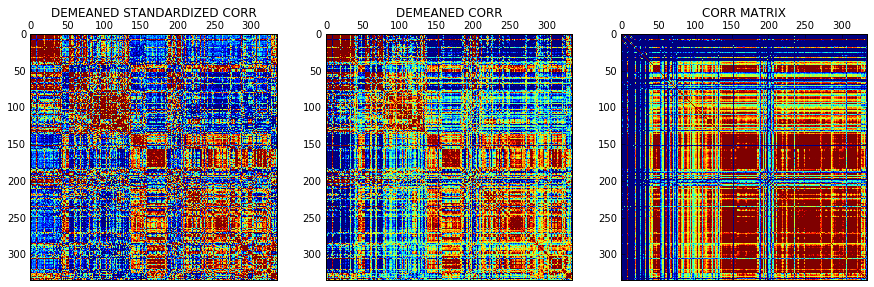

In [51]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5.5))

axs[0].matshow(demean(stand(demean(cor_mat))), vmin = -10, vmax = 10)
axs[0].set_title('DEMEANED STANDARDIZED CORR')
axs[1].matshow(demean(cor_mat), vmin = -.1, vmax = .1)
axs[1].set_title('DEMEANED CORR')
axs[2].matshow(cor_mat.fillna(0), vmin = .2, vmax = .7)
axs[2].set_title('CORR MATRIX')

# plt.hist(stand(demean(cor_mat)).std(), 30)
plt.show()

## Spectral clustering of corr matrix
on the demeaned correlation matrix

In [52]:
# Works better when matrix is demeaned
from sklearn.cluster import SpectralClustering
X_ = demean(cor_mat).values
clustering = SpectralClustering(n_clusters=10,
        assign_labels="discretize",
        random_state=0).fit(X_)

pd.options.display.max_rows = 500
clust_result = pd.DataFrame(clustering.labels_, index = X.columns, columns = ['cluster'])
clust_result = pd.concat([clust_result, industry_titles.set_index('industry_code')], axis = 1, sort = False).dropna().sort_values(by = ['cluster', 'industry_title'])

ValueError: Shape of passed values is (2, 2513), indices imply (2, 2505)

# Networks

We will follow these steps:

     [-] Create clean datasets of edges and nodes

     [-] Calculate a layout (x, y positions) using module networkx

     [-] Draw interactive plots using d3plus

### Edges

In [58]:
# on the demeaned correlation matrix
edges = pd.DataFrame(demean(cor_mat).stack(), columns = ['dem_corr'])


edges_s = edges.loc[edges.dem_corr > edges.dem_corr.quantile(.9)]
edges_s.index.names = ['industry_code_x', 'industry_code_y']
edges_s = edges_s.reset_index().merge(
    industry_titles, left_on = 'industry_code_x', right_on = 'industry_code').merge(
    industry_titles, left_on = 'industry_code_y', right_on = 'industry_code').T.drop_duplicates().T
edges_s['dem_corr'] = edges_s['dem_corr'].astype(float)

edges_s.sample(5)

,industry_code_x,industry_code_y,dem_corr,industry_title_x,industry_title_y
152,4841,2381,0.115176,NAICS 4841 General freight trucking,NAICS 2381 Building foundation and exterior contractors
3931,1129,1153,0.210344,NAICS 1129 Other animal production,NAICS 1153 Support activities for forestry
3184,3253,1122,0.117110,NAICS 3253 Agricultural chemical manufacturing,NAICS 1122 Hog and pig farming
2590,2131,Water,0.307124,NAICS 2131 Support activities for mining,Water
437,4421,4421,0.247961,NAICS 4421 Furniture stores,NAICS 4421 Furniture stores


### Nodes

on the demeaned correlation matrix

In [59]:
import matplotlib.colors as mcolors

# nodes = industry_titles

nodes_size = pd.DataFrame(np.sqrt(X.sum()), columns=['sqrt_size'])
nodes = pd.concat([nodes_size, clust_result], axis = 1, sort = False)

norm = mcolors.Normalize(vmin=0, vmax=10, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.jet)

nodes['color'] = nodes['cluster'].apply(lambda x: mcolors.rgb2hex(mapper.to_rgba(x)))

nodes.sample(5)

,sqrt_size,cluster,color
5321,123.805760,8,#ff6800
4921,100.927750,8,#ff6800
Woodland,24.054191,9,#f10800
7121,90.890954,0,#000080
4233,140.003451,8,#ff6800


***Edge trimming*** by asking max degree. Mostly this is applied so that small industries with no points don't show connections(high corr) with a lot of other industries just because of few point avg outlier effect.

In [ ]:
max_d = 40
weight_column = 'dem_corr' 

        ### Max degree = max_d. Parameter used to trim the network.
df1 = edges_s.groupby('industry_code_x').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
df2 = edges_s.groupby('industry_code_y').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
edges_max_d = df1.merge(df2, on = ['industry_code_x', 'industry_title_x', 'industry_code_y', 'industry_title_x', weight_column]).reset_index(drop = True)


### Use networkx to come up with a layout

In [54]:
# Hard threshold and max degree backboning

G = nx.from_pandas_edgelist(edges_max_d, 'industry_code_x', 'industry_code_y', weight_column)


plt.figure(figsize = (10, 8))

G = max(nx.connected_component_subgraphs(G), key=len)
nodes_s = nodes.loc[G.nodes.keys()]
### GET NODES POSITION!!
pos = nx.spring_layout(G, k=.4) 

# DRAW. USEFUL FOR DEBUGGING.
# nx.draw(G, pos, node_size = nodes_s.sqrt_size.values, alpha=.6, node_color= list(nodes_s.color.values), edgelist = [])
# nx.draw_networkx_edges(G, pos, edge_color='.7', alpha=.3)

# plt.show()

### Draw in d3plus

In [18]:
# Position
pos_df = pd.DataFrame(pos, index = ['x', 'y']).T
nodes_wpos = pd.concat([nodes_s, pos_df], axis = 1, sort = False)

In [19]:
# Create a new nodes dataframe which will be used with d3plus
nodes_ = nodes_wpos.reset_index()[['index','x', 'y', 'industry_title', 'color']].dropna(subset = ['x']).rename({'index': 'id'}, axis = 1)
nodes_['id'] = nodes_['id'].astype(str).str.zfill(4)
nodes_[['x', 'y']] = 500 * nodes_[['x', 'y']]


In [20]:
nodes_.head()

,id,x,y,industry_title,color
0,1142,-223.802996,369.179206,NAICS 1142 Hunting and trapping,#0000f1
1,5173,79.357574,13.872119,NAICS 5173 Wired and wireless telecommunicatio...,#ffc400
2,1141,-173.021955,299.538367,NAICS 1141 Fishing,#004cff
3,3335,-316.831693,-72.861679,NAICS 3335 Metalworking machinery manufacturing,#000080
4,5175,196.421357,369.755870,NAICS02 5175 Cable and other program distribution,#000080


In [21]:
# nodes_.sort_values(by = 'id')#.loc[nodes_.id == 'Desert']

In [22]:
# import sys
# sys.path.append("./../Hidalgo_Haussmann") # for HH tools
# import pandas as pd
# from HH_tools import robust_proximity, year_to_tp, RCA

We need to create a 'network' json string. It is a text that contains all network information and it's what d3plus needs for plotting

In [23]:
nodes_['presence'] = True

edges_max_d['edge_tuple'] = list(zip(edges_max_d.industry_code_x, edges_max_d.industry_code_y))
edges_max_d['edge_tuple_rev'] = list(zip(edges_max_d.industry_code_y, edges_max_d.industry_code_x))
edges_max_d_triangles = edges_max_d.loc[edges_max_d.edge_tuple.isin(G.edges()) | edges_max_d.edge_tuple_rev.isin(G.edges())]

links = edges_max_d_triangles.reset_index().rename({weight_column: 'strength'},axis = 1)
links['target'] = links['industry_code_y'].astype(str).str.zfill(4)
links['source'] = links['industry_code_x'].astype(str).str.zfill(4)

network = '{"nodes": '+nodes_.to_json(orient= 'records')+', "edges": '+links[['index', 'source', 'target']].to_json(orient= 'records')+'}\n'

In [24]:
# ## Conditional coloring

# # Manufacturing (light_blue) and services (yellow)
# nodes_['color_mfg_srv'] = 'D3D3D3' #Gray bckg

# conditions = [
#     (nodes_['industry_title'].str.lower().str.contains('manufacturing')) + (nodes_['industry_title'].str.lower().str.contains('mfg')),
#     (nodes_['industry_title'].str.lower().str.contains('service')),# or (nodes_['industry_title'].str.lower().str.contains('mfg')),
#     (nodes_['industry_title'].str.lower().str.contains('wholesale')),# or (nodes_['industry_title'].str.lower().str.contains('mfg')),
#     (-nodes_['industry_title'].str.lower().str.contains('naics'))]

# choices = ['#000080', '#ffc400', '#00b0ff', '#000000']

# nodes_['color_mfg_srv'] = np.select(conditions, choices, default='#D3D3D3')


/home/miglesia/anaconda2/lib/python2.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [25]:
edges_max_d_triangles.to_csv('edges_max_d_triangles.csv', index = False)

In [60]:
ps = d3plus.ProductSpace(
id="name",
name="industry_title",
color="color",
# color="color_mfg_srv",
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")
ps.draw(nodes_)

<IPython.core.display.Javascript object>

# Analysis of network result
### What are the colored clusters?

In [28]:
pd.set_option('display.max_colwidth', -1)
summary = nodes.loc[nodes.industry_title.str.contains('NAICS')].groupby('cluster').agg({'industry_title': 'first', 'color':[ 'first', 'count']})
summary.columns = ['color', 'node_count','example']
summary.sort_index()#.sort_values(by = 'node_count')

,color,node_count,example
cluster,,,
0.0,#000080,80,NAICS 1152 Support activities for animal production
1.0,#0000f1,12,NAICS 1142 Hunting and trapping
2.0,#004cff,22,NAICS 1114 Greenhouse and nursery production
3.0,#00b0ff,36,NAICS 2212 Natural gas distribution
4.0,#29ffce,6,NAICS 1125 Aquaculture
5.0,#7dff7a,69,NAICS 2361 Residential building construction
6.0,#ceff29,6,NAICS 2111 Oil and gas extraction
7.0,#ffc400,76,NAICS 2362 Nonresidential building construction
8.0,#ff6800,3,NAICS 1111 Oilseed and grain farming


### Show 

In [69]:
# land-use clusters

def node_list_by_color(hexstrings,nodes_df = nodes_):
    return nodes_df.loc[nodes_df['color'].isin(hexstrings)].sort_values(by = ['color','industry_title'])

# Check color codes
# ['#f10800', '#ff6800', '#ceff29', '#29ffce'] #Land/commodities
# ['#7dff7a'] #population cluster
# ['#ffc400'] #'yellow' services cluster
# ['#004cff'] #state/public sector cluster
# ['#000080', '#0000f1', '#00b0ff'] #others/mfg clusters
# ['#0000f1'] # coastal?

# Print nodes of that color
hexstrings = ['#ffc400']
node_list_by_color(hexstrings).sample(10)


,id,x,y,industry_title,color,presence,color_mfg_srv
24,5172,416.852541,-141.899897,NAICS12 5172 Wireless telecommunications carriers,#ffc400,True,#D3D3D3
77,5615,208.034318,-69.770396,NAICS 5615 Travel arrangement and reservation services,#ffc400,True,#ffc400
62,4232,185.602270,-14.890866,NAICS 4232 Furniture and furnishing merchant wholesalers,#ffc400,True,#00b0ff
121,5419,178.350032,-160.715775,NAICS 5419 Other professional and technical services,#ffc400,True,#ffc400
232,4246,126.202948,-138.963277,NAICS 4246 Chemical merchant wholesalers,#ffc400,True,#00b0ff
160,4237,162.118133,-131.564218,NAICS 4237 Hardware and plumbing merchant wholesalers,#ffc400,True,#00b0ff
247,4922,432.288413,-11.502155,NAICS 4922 Local messengers and local delivery,#ffc400,True,#D3D3D3
222,6215,299.527447,-253.652334,NAICS 6215 Medical and diagnostic laboratories,#ffc400,True,#D3D3D3
201,6115,413.027578,-277.230106,NAICS 6115 Technical and trade schools,#ffc400,True,#D3D3D3
187,5231,115.315722,-41.516288,NAICS 5231 Securities and commodity contracts brokerage,#ffc400,True,#D3D3D3


### Keywords by cluster

In [31]:
# Cluster 7, #ffc400 are 76 nodes that follow neither population nor land resources. Then what is it all about?
from collections import Counter
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 

from IPython.display import display, HTML
import colorlover as cl    
    
for clsr in range(10):
    try:
        
        text = nodes.loc[nodes.cluster == clsr]['industry_title']

        r1 = text.str.lower().str.split().values
        r1 = [item for sublist in r1 for item in sublist]

        r1_f = [w.replace(',', '').replace('mfg.', 'manufacturing') for w in r1 if not w in stop_words] 

        print(summary.loc[clsr])
        color = summary.loc[clsr]['color']
        display(HTML(cl.to_html( [tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))] )))
        print(Counter(r1_f).most_common()[:10])
        print('\n')
    except:
        pass

color         #000080                                            
node_count    80                                                 
example       NAICS 1152 Support activities for animal production
Name: 0.0, dtype: object


[('naics', 79), ('manufacturing', 33), ('product', 11), ('equipment', 6), ('transportation', 4), ('general', 4), ('machinery', 4), ('facilities', 3), ('merchant', 3), ('furniture', 3)]


color         #0000f1                        
node_count    12                             
example       NAICS 1142 Hunting and trapping
Name: 1.0, dtype: object


[('naics', 12), ('transportation', 3), ('mills', 3), ('product', 2), ('manufacturing', 2), ('1142', 1), ('coastal', 1), ('4245', 1), ('packaging', 1), ('raw', 1)]


color         #004cff                                     
node_count    22                                          
example       NAICS 1114 Greenhouse and nursery production
Name: 2.0, dtype: object


[('naics', 22), ('transportation', 4), ('water', 3), ('manufacturing', 3), ('production', 2), ('activities', 2), ('scenic', 2), ('sightseeing', 2), ('mining', 2), ('administration', 2)]


color         #00b0ff                            
node_count    36                                 
example       NAICS 2212 Natural gas distribution
Name: 3.0, dtype: object


[('naics', 36), ('manufacturing', 19), ('product', 7), ('transportation', 5), ('steel', 3), ('mills', 3), ('equipment', 3), ('production', 2), ('motor', 2), ('vehicle', 2)]


color         #29ffce               
node_count    6                     
example       NAICS 1125 Aquaculture
Name: 4.0, dtype: object


[('naics', 6), ('operations', 1), ('activities', 1), ('mining', 1), ('logging', 1), ('3211', 1), ('1133', 1), ('1131', 1), ('woodland', 1), ('1125', 1)]


color         #7dff7a                                     
node_count    69                                          
example       NAICS 2361 Residential building construction
Name: 5.0, dtype: object


[('naics', 65), ('stores', 17), ('services', 9), ('care', 7), ('building', 5), ('offices', 4), ('goods', 4), ('contractors', 4), ('activities', 3), ('supplies', 3)]


color         #ceff29                          
node_count    6                                
example       NAICS 2111 Oil and gas extraction
Name: 6.0, dtype: object


[('naics', 6), ('oil', 2), ('transportation', 2), ('gas', 2), ('pipeline', 2), ('9271', 1), ('technology', 1), ('2131', 1), ('3365', 1), ('support', 1)]


color         #ffc400                                        
node_count    76                                             
example       NAICS 2362 Nonresidential building construction
Name: 7.0, dtype: object


[('naics', 72), ('services', 23), ('merchant', 12), ('wholesalers', 12), ('related', 5), ('goods', 4), ('support', 4), ('telecommunications', 4), ('carriers', 4), ('equipment', 4)]


color         #ff6800                             
node_count    3                                   
example       NAICS 1111 Oilseed and grain farming
Name: 8.0, dtype: object


[('naics', 3), ('farming', 2), ('1111', 1), ('mining', 1), ('2122', 1), ('oilseed', 1), ('ore', 1), ('1122', 1), ('metal', 1), ('cropland', 1)]


color         #f10800                               
node_count    9                                     
example       NAICS 1112 Vegetable and melon farming
Name: 9.0, dtype: object


[('naics', 9), ('farming', 5), ('crop', 2), ('production', 2), ('forest', 2), ('gathering', 1), ('1121', 1), ('nut', 1), ('1123', 1), ('1124', 1)]




### Map distribution from different clusters

In [70]:
# nodes
import geopandas as gpd

counties = gpd.read_file('./data/cb_2017_us_county_500k/cb_2017_us_county_500k.shp')
counties['area_fips'] = counties.STATEFP + counties.COUNTYFP


OSError: [Errno 12] Cannot allocate memory

In [ ]:
### A little trick. Distribution of neigbors of node 'Naics 5417 Scientific Research and Development Services'
# nodes_.loc[nodes_.id == '5417']
ego_node = 'Desert' #'Cropland' #'POPESTIMATE2010'# '5417'

neigh = edges_max_d_triangles.loc[(edges_max_d_triangles.industry_code_x == ego_node) |
                                  (edges_max_d_triangles.industry_code_y == ego_node)]
neigh_ids = list(set(neigh['industry_code_x'].unique()).union(set(neigh['industry_code_y'].unique())))
# nodes_.loc[nodes_.id.isin(neigh_ids)]['id'].values

node_ids = neigh_ids

In [ ]:
# gdf.loc[gdf.industry_code == naics]['annual_avg_estabs']
# df_neigh
# df_neigh.groupby('industry_code').mean().sort_values(by = 'annual_avg_estabs').tail(5).index

In [ ]:
from PIL import Image, ImageDraw, ImageFont


In [ ]:
# Choose indus to process...
n = 5
merged = df_agglv_yravg.groupby(level = 1)['annual_avg_estabs'].sum().reset_index().merge(nodes_, left_on = 'industry_code', right_on = 'id')
display_indus = merged.loc[merged.groupby('color')['annual_avg_estabs'].nlargest(n).index.get_level_values(1)]

#Filter original data to have these neighboring industries
df_agglv = df.loc[df.agglvl_code == 76]

df_agglv_yravg = df_agglv.groupby(['area_fips', 'industry_code']).mean().drop(['agglvl_code','year'], axis = 1)
# df_indu_prc_area = df_agglv_yravg.groupby(level=0).apply(lambda x: 100 * x / x.sum())
df_indu_prc_area = log10(df_agglv_yravg)

df_ = df_indu_prc_area.reset_index()

i = 0
open('./Figures/7_compo_USA_nw/labels.txt', 'w').close()
for color in nodes_.color.unique():
  
    cluster_ids = nodes_.loc[nodes_.color == color]['id']
    node_ids = cluster_ids.values
    
    df_neigh = df_.loc[df_.industry_code.isin(nodes_.loc[nodes_.id.isin(node_ids)]['id'].values)]
    df_neigh = df_neigh.set_index('area_fips')
    
    counties_ = counties.set_index('area_fips').reindex(df_neigh.index)[['geometry']]
    gdf = gpd.GeoDataFrame(pd.concat([df_neigh, counties_], axis = 1, sort = True).dropna())

    # Sample of cluster color
    rgb_tuple = tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))
    im = Image.new('RGBA', (20, 20), rgb_tuple)
    im.save('./Figures/7_compo_USA_nw/cp_'+str(i)+'.png')

    for naics in display_indus['industry_code'].values:
        if( gdf.loc[gdf.industry_code == naics]['annual_avg_estabs'].mean() > .2 ):#& (i <=5): # Dismiss small indus
            node_info = nodes_.loc[nodes_.id == naics]
            
            # send node labels to test (they will then go to svg of figure)
            with open('./Figures/7_compo_USA_nw/labels.txt', 'a') as f:
                f.write(node_info['industry_title'].values[0]+'\n')
            display(node_info)
            display(HTML(cl.to_html( [rgb_tuple] )))

            ax = gdf.loc[gdf.industry_code == naics].plot(
                column='annual_avg_estabs', cmap=plt.cm.gist_yarg, vmin = 0, vmax = 1.5, linewidth = 0, figsize = (10, 6.5))
            ax.set_xlim(-130, -60)
            ax.set_ylim(22, 50)#, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
#             plt.axis('off')
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            plt.text(-128, 23.5, 'NAICS '+str(node_info['id'].values[0]), fontsize=30) # position in lat lon
            plt.savefig('./Figures/7_compo_USA_nw/'+str(node_info['id'].values[0])+'.png', bbox_inches = 'tight')
            plt.show()
    i+=1

In [ ]:
# TXT2InkscapeXMLv3.py

# A simple Python 3 script to look through a list of text and
# turn each line into an xml entry for use in Inkscape.
# in this script we will slightly spread the text to allow
# the user a better chance of retaining the order of their
# initial text.  Inkscape can be used to spread it out
# using the Align and Distribute Tool.


ofilenm = './Figures/7_compo_USA_nw/figure.svg'#str(input("What is the filename you wish for output?"))
outfile = open(ofilenm,"w")

ListFlm = './Figures/7_compo_USA_nw/labels.txt'#str(input("What is the name and location of the TXT file to work with?"))

Loctn = 75 #Vertical position to start text insertion
SpacingV = 25  #The vertical spacing between lines.

# The block that follows is the Inkscape standard header.
TextBlockA = '''<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!-- Created with Inkscape (http://www.inkscape.org/) -->

<svg
   xmlns:dc="http://purl.org/dc/elements/1.1/"
   xmlns:cc="http://creativecommons.org/ns#"
   xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
   xmlns:svg="http://www.w3.org/2000/svg"
   xmlns="http://www.w3.org/2000/svg"
   xmlns:sodipodi="http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd"
   xmlns:inkscape="http://www.inkscape.org/namespaces/inkscape"
   width="744.09448819"
   height="1052.3622047"
   id="svg2"
   version="1.1"
   inkscape:version="0.48.4 r9939"
   sodipodi:docname="New document 1">
  <defs
     id="defs4" />
  <sodipodi:namedview
     id="base"
     pagecolor="#ffffff"
     bordercolor="#666666"
     borderopacity="1.0"
     inkscape:pageopacity="0.0"
     inkscape:pageshadow="2"
     inkscape:zoom="0.35"
     inkscape:cx="375"
     inkscape:cy="520"
     inkscape:document-units="px"
     inkscape:current-layer="layer1"
     showgrid="false"
     inkscape:window-width="1280"
     inkscape:window-height="742"
     inkscape:window-x="-2"
     inkscape:window-y="-3"
     inkscape:window-maximized="1" />
  <metadata
     id="metadata7">
    <rdf:RDF>
      <cc:Work
         rdf:about="">
        <dc:format>image/svg+xml</dc:format>
        <dc:type
           rdf:resource="http://purl.org/dc/dcmitype/StillImage" />
        <dc:title></dc:title>
      </cc:Work>
    </rdf:RDF>
  </metadata>
  <g
     inkscape:label="Layer 1"
     inkscape:groupmode="layer"
     id="layer1">'''

TextBlockB = '''<text\n
        xml:space="preserve"
        style="font-size:20px;font-style:normal;font-weight:normal;line-height:125%;letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;font-family:Sans"
        x="93.910118"
        y="'''
TextBlockC = '''id="text2989"
        sodipodi:linespacing="150%"><tspan
            sodipodi:role="line"
            id="tspan2991"
            x="93.910118"
            y="'''

outfile.write(TextBlockA)

# The section that follows is to build the SVG text elements
f = open(ListFlm,"r")
for line in f:
    TXTLine = line.strip()
    Loctn = Loctn + SpacingV
    InsertStrng1 = str(Loctn)+'"\n'
    InsertStrng2= str(Loctn)+'">'+TXTLine+'</tspan></text>\n'
    outfile.write(TextBlockB)
    outfile.write(InsertStrng1)
    outfile.write(TextBlockC)
    outfile.write(InsertStrng2)

# The next section is the close off for the SVG xml.

outfile.write('  </g>\n')
outfile.write('</svg>\n')

outfile.close()
print("Done")

In [ ]:
# Choose indus to process...
n = 5
merged = df_agglv_yravg.groupby(level = 1)['annual_avg_estabs'].sum().reset_index().merge(nodes_, left_on = 'industry_code', right_on = 'id')
display_indus = merged.loc[merged.groupby('color')['annual_avg_estabs'].nlargest(n).index.get_level_values(1)]

#Filter original data to have these neighboring industries
df_agglv = df.loc[df.agglvl_code == 76]

df_agglv_yravg = df_agglv.groupby(['area_fips', 'industry_code']).mean().drop(['agglvl_code','year'], axis = 1)
# df_indu_prc_area = df_agglv_yravg.groupby(level=0).apply(lambda x: 100 * x / x.sum())
df_indu_prc_area = log10(df_agglv_yravg)

df_ = df_indu_prc_area.reset_index()

for color in nodes_.color.unique():
  
    cluster_ids = nodes_.loc[nodes_.color == color]['id']
    node_ids = cluster_ids.values
    
    df_neigh = df_.loc[df_.industry_code.isin(nodes_.loc[nodes_.id.isin(node_ids)]['id'].values)]
    df_neigh = df_neigh.set_index('area_fips')
    
    counties_ = counties.set_index('area_fips').reindex(df_neigh.index)[['geometry']]
    gdf = gpd.GeoDataFrame(pd.concat([df_neigh, counties_], axis = 1, sort = True).dropna())
    
    for naics in display_indus['industry_code'].values:
        if( gdf.loc[gdf.industry_code == naics]['annual_avg_estabs'].mean() > .45 ):#& (i <=5): # Dismiss small indus
            display(nodes_.loc[nodes_.id == naics])
            display(HTML(cl.to_html( [tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))] )))

            ax = gdf.loc[gdf.industry_code == naics].plot(
                column='annual_avg_estabs', cmap=plt.cm.gist_yarg, vmin = 0, vmax = 1.5, linewidth = 0, figsize = (10, 6.5))
            ax.set_xlim(-130, -60)
            ax.set_ylim(22, 50)#, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
            plt.show()
            i+=1

### Color by Population Density

In [ ]:
processed_data_path = './../../../../../media/miglesia/Elements/corr_st_data/'

main_tables = pd.concat([pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2011_2012.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2011_2013.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2012_2013.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2011.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2012.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2013.csv')])

main_table = main_tables.groupby('CHI ID COM').mean()/2.

# change node names into node index
# main_table.rename(columns = dict(zip(nodes.node_name, nodes.index)), inplace = True)

population = pd.read_csv('./data/pop_dist_comuna.csv').rename(columns = {'comuna_id': 'CHI ID COM'})

In [ ]:
from numpy import log10
population['log_dens'] = log10(population['densidad'])
b = 8; population['log_dens_cat'] = pd.cut(population['log_dens'], b)

bins = pd.cut(population['log_dens'], b, retbins=True)[1]
bins_mean = (bins[1:] + bins[:-1])/2.

merged = pd.concat([population.set_index('CHI ID COM')[['log_dens_cat']].sort_index(), main_table], axis = 1)
popdens_RCA = RCA(merged.groupby('log_dens_cat').sum())

popdens_RCA_normed = popdens_RCA/popdens_RCA.sum()

In [ ]:
nodes_

In [ ]:
# pop_dens_index = pd.DataFrame((popdens_RCA_normed.T*bins_mean).T.sum(), columns = ['pop_dens_index'])
# pop_dens_index = pop_dens_index.reset_index().rename(columns={'index':'id'})
# nodes_ = nodes_.merge(pop_dens_index, on = 'id', how = 'left') # industry_title / node_name
# # nodes_['pop_dens_color_code'] = pd.cut(nodes_['pop_dens_index'], bins = 7, labels=False)

# from numpy import nan
# rainbow_colors = {0:'#9400D3', #Violet
# 1:'#4B0082', #Indigo
# 2:'#0000FF', #Blue
# 3:'#00FF00', #Green
# nan:'#D3D3D3',  #'#D3D3D3', #Gray
# 4:'#FFFF00', #Yellow
# 5:'#FF7F00', #Orange
# 6:'#FF0000'} #Red

# nodes_['color_2'] = pd.DataFrame(nodes_['pop_dens_color_code'].map(rainbow_colors))

# network = '{"nodes": '+nodes_.to_json(orient= 'records')+', "edges": '+links[['index', 'source', 'target']].to_json(orient= 'records')+'}\n'

In [ ]:
ps = d3plus.ProductSpace(
id="name",
name="node_name",
color="color_2",
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")
ps.draw(nodes_)

In [ ]:
plt.hist(edges.weight_CHI_COM.values, 50)
plt.hist(edges_max_d.weight_CHI_COM.values, 50)
plt.show()